In [14]:
import os
import glob
import torch
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from transformers import CLIPImageProcessor
from safetensors.torch import load_file
from model.configuration_uniflow import UniFlowVisionConfig
from model.modeling_uniflow import UniFlowVisionModel
from skimage.metrics import peak_signal_noise_ratio as psnr_loss
from skimage.metrics import structural_similarity as ssim_loss

config_path = r'.\uniflow'
config = UniFlowVisionConfig.from_pretrained(config_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UniFlowVisionModel(config=config).to(device, dtype=torch.bfloat16).eval()

ckpt_st = r'.\uniflow\model.safetensors'
state_dict = load_file(ckpt_st)
model.load_state_dict(state_dict, strict=False)

DATA_NORM = {"imagenet": {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}}
data_norm = 'imagenet'
def center_crop_arr(pil_image, image_size):
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(tuple(x // 2 for x in pil_image.size), resample=Image.BOX)
    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC)
    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size])
transform = transforms.Compose([
    transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_NORM[data_norm]['mean'], std=DATA_NORM[data_norm]['std'], inplace=True)
])
def read_proc(path):
    img = Image.open(path).convert('RGB')
    return img, transform(img).unsqueeze(0)  # (PIL, Tensor[1,3,448,448])

mean = torch.tensor(DATA_NORM[data_norm]['mean']).view(1, 3, 1, 1)
std  = torch.tensor(DATA_NORM[data_norm]['std']).view(1, 3, 1, 1)

Sampling Step: 1


PSNR = 32.35 dB
SSIM = 0.9547


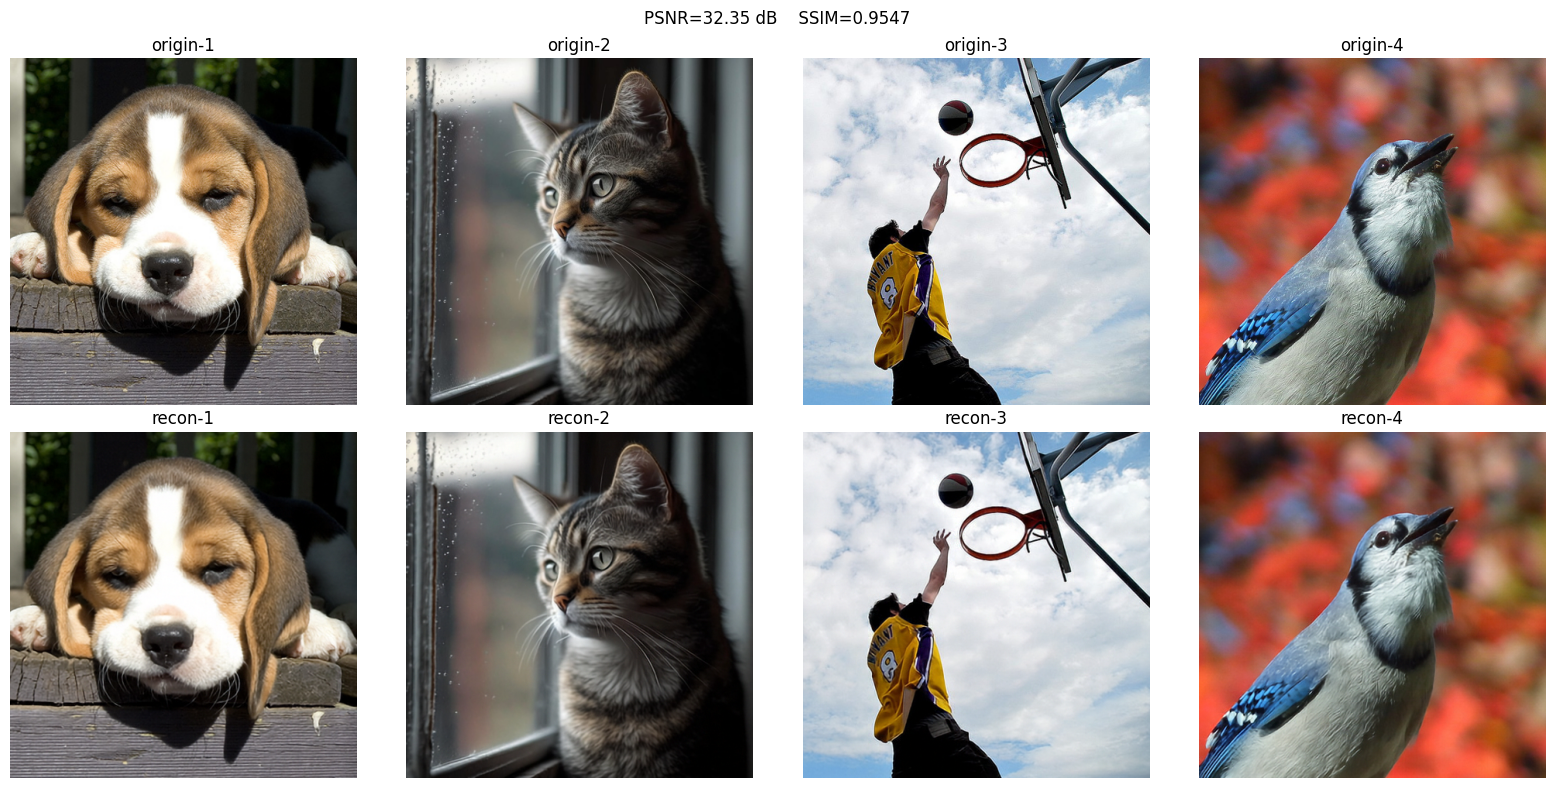

In [17]:
# Randomly sample 4 images from the assets directory
assets_dir = Path(r'.\assets')
all_pngs = list(assets_dir.glob('*.png'))
img_paths = random.sample(all_pngs, 4)
imgs_raw, tensor_list = zip(*[read_proc(p) for p in img_paths])
pv_batch = torch.cat(tensor_list, dim=0).to(device=device, dtype=torch.bfloat16)

with torch.no_grad():
    recons = model(pv_batch)

recons = recons.float().cpu()
std = std.to(recons.device)
mean = mean.to(recons.device)
recons = (recons * std + mean).clamp(0, 1)
recons_np = (recons.permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)

def compute_metrics(img1, img2):
    img1_np = np.asarray(img1.resize((448, 448), Image.LANCZOS), dtype=np.float32) / 255.
    img2_np = np.asarray(img2, dtype=np.float32) / 255.
    ssim_val = ssim_loss(img1_np, img2_np, multichannel=True, data_range=2.0, channel_axis=-1)
    psnr_val = psnr_loss(img1_np, img2_np)
    return psnr_val, ssim_val

psnr_vals, ssim_vals = zip(*[compute_metrics(im, Image.fromarray(rc))
                             for im, rc in zip(imgs_raw, recons_np)])
psnr_mean, ssim_mean = np.mean(psnr_vals), np.mean(ssim_vals)
print(f'PSNR = {psnr_mean:.2f} dB')
print(f'SSIM = {ssim_mean:.4f}')

plt.figure(figsize=(16, 8))
for col in range(4):
    ax1 = plt.subplot(2, 4, col + 1)
    ax1.imshow(np.asarray(imgs_raw[col].resize((448, 448), Image.LANCZOS)))
    ax1.set_title(f'origin-{col+1}')
    ax1.axis('off')

    ax2 = plt.subplot(2, 4, col + 5)
    ax2.imshow(recons_np[col])
    ax2.set_title(f'recon-{col+1}')
    ax2.axis('off')

plt.suptitle(f'PSNR={psnr_mean:.2f} dB    SSIM={ssim_mean:.4f}', y=0.98)
plt.tight_layout()
save_path = os.path.join(f'assets_vis_2x4.png')
plt.savefig(save_path, dpi=400)
plt.show()